In [96]:
# Checkpoint to begin loading the Showdown data set

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as sp

gen5_types_df = pd.read_csv("./dataset/pokemon-fandom/pokemon_gen5_types_fixed.csv")
gen5_stats_df = pd.read_csv(r"dataset/bulbagarden/pokemon_gen5_stats.csv")
pokemon_counts_df = pd.read_csv("./dataset/showdown/showdown_2players.csv")
unique_pokemons_df = pd.read_csv("unique_pokemons.csv")
gen5ou_usage_latest = pd.read_csv("./dataset/smogon/2025-06-gen5ou-0.csv")

Each Pokemon in the Showdown dataset, including those used multiple times by the same players, has been counted and converted to a data frame.

In [97]:
showdown_pokemon = pd.concat([pokemon_counts_df["Player " + str(m) + " Pokemon " + str(n)] for m in range(1, 3) for n in range(1, 7)], ignore_index=True)
showdown_pokemon.value_counts()
# Convert to DataFrame
df_counts = showdown_pokemon.value_counts().reset_index()

# Rename columns for clarity
df_counts.columns = ['Pokemon', 'Observed']


The Smogon dataset as well has been converted to a data frame only keeping the number of raw matches for each Pokemon.

In [98]:
pokemon_usage_expected = gen5ou_usage_latest.drop(["Usage%", "%", "Real", "%.1", "Rank"], axis=1)
pokemon_usage_expected

,Pokemon,Raw
0,Latios,24477
1,Tyranitar,23277
2,Ferrothorn,22418
3,Starmie,21626
4,Garchomp,20896
...,...,...
471,Ledian,1
472,Tirtouga,1
473,Minccino,1
474,Darumaka,1


During a scrapped Goodness of Fit test, Politoed was seen to be the biggest contributor to the incredibly high Chi-Square value, due to being used more than 80% than what was expected. Due to this, a Bayesian Inference was conducted specifically for Politoed in order to determine whether its incredibly high usage observed in the replays is significant when used as evidence to the prior belief created through the Smogon database.

Showwn below is the data that will be useful for conducting the Bayesian Inference test.

In [99]:
totalPolitoedReplay = df_counts[df_counts["Pokemon"] == "Politoed"]["Observed"].iloc[0]
totalPolitoed = pokemon_usage_expected[pokemon_usage_expected["Pokemon"] == "Politoed"]["Raw"].iloc[0]
totalPokemon = pokemon_usage_expected["Raw"].sum()
totalTeams = int(np.floor(pokemon_usage_expected["Raw"].sum() / 6))
print("Total Politoed uses in database: " + str(totalPolitoed))
print("Total Pokemon used: " + str(totalPokemon))
print("Total Pokemon teams: " + str(totalTeams))

Total Politoed uses in database: 11810
Total Pokemon used: 531591
Total Pokemon teams: 88598


Once all the useful data has been stored in accessible variables, the Prior and Posterior beliefs are calculated. With the formula P(θ | α, β) for prior belief and P(θ | z + α, N - z + β) where z is the observed values while N is the number of trials, the prior and posterior beliefs are calculated.

In [100]:
# Prior Data from Smogon Database
alpha_prior = totalPolitoed
beta_prior = totalTeams - alpha_prior

print("Prior Belief: Beta(" + str(alpha_prior) + ", " + str(beta_prior) + ")")

alpha_posterior = alpha_prior + totalPolitoedReplay
beta_posterior = beta_prior + (10000 - totalPolitoedReplay)

print("Posterior Belief: Beta(" + str(alpha_posterior) + ", " + str(beta_posterior) + ")")


Prior Belief: Beta(11810, 76788)
Posterior Belief: Beta(14203, 84395)


After calculating the Prior and Posterior Beliefs, the Bayes Factor is calculated using the formula below.

In [101]:
prior_mean = alpha_prior / (alpha_prior + beta_prior)
prior_odds = prior_mean / (1 - prior_mean)

posterior_mean = alpha_posterior / (alpha_posterior + beta_posterior)
posterior_odds = posterior_mean / (1 - posterior_mean)

bayes_factor = posterior_odds / prior_odds
print("BF = " + str(format(bayes_factor, ".4f")))

BF = 1.0942


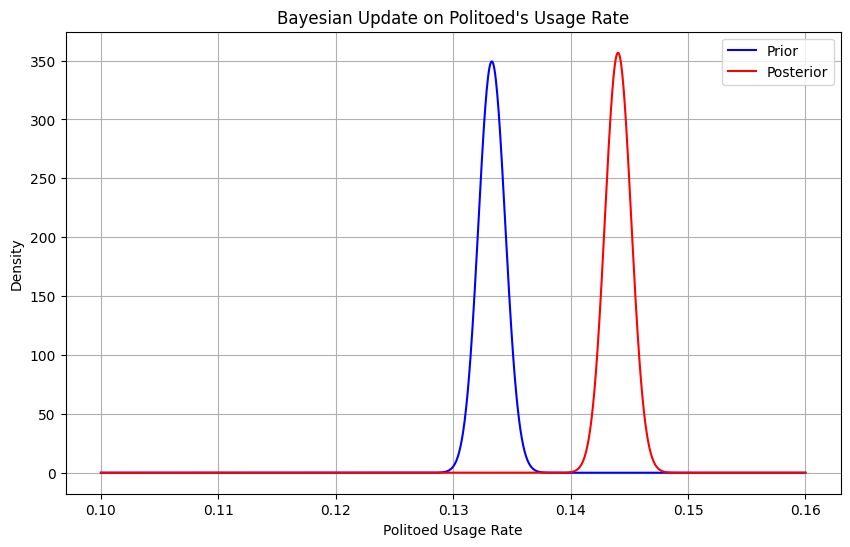

In [102]:
x_vals = np.linspace(0.1, 0.16, 1000)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_vals, sp.beta.pdf(x_vals, alpha_prior, beta_prior), label="Prior", color="blue")
plt.plot(x_vals, sp.beta.pdf(x_vals, alpha_posterior, beta_posterior), label="Posterior", color="red")
plt.title("Bayesian Update on Politoed's Usage Rate")
plt.xlabel("Politoed Usage Rate")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [103]:
# pokemonList = df_counts[pokemon_usage_expected["Raw"] > 100]["Pokemon"]

In [104]:
merged_df = df_counts.merge(pokemon_usage_expected[["Pokemon", "Raw"]], on="Pokemon")

# List of Pokemon to do Bayesian Inference on
pokemonList = merged_df[merged_df["Raw"] > 1]["Pokemon"].tolist()

totalPokemon = pokemon_usage_expected["Raw"].sum()
totalTeams = int(np.floor(totalPokemon / 6))

# If you want to print Bayesian Values
printing = False

print("Total Pokemon used: " + str(totalPokemon))
print("Total Pokemon teams: " + str(totalTeams))
print("\n")

results = []

for pokemon in pokemonList:
    totalPokemonReplay = df_counts[df_counts["Pokemon"] == pokemon]["Observed"].iloc[0]
    
    expected_data = pokemon_usage_expected[pokemon_usage_expected["Pokemon"] == pokemon]
    
    if expected_data.empty:
        print("Skipping " + pokemon + " — not found in expected data\n")
        continue

    totalPokemonUsageExpected = expected_data["Raw"].iloc[0]

    # Prior Data from Smogon Database
    alpha_prior = totalPokemonUsageExpected
    beta_prior = totalTeams - alpha_prior

    alpha_posterior = alpha_prior + totalPokemonReplay
    beta_posterior = beta_prior + (10000 - totalPokemonReplay)

    prior_mean = alpha_prior / (alpha_prior + beta_prior)
    prior_odds = prior_mean / (1 - prior_mean)

    posterior_mean = alpha_posterior / (alpha_posterior + beta_posterior)
    posterior_odds = posterior_mean / (1 - posterior_mean)

    bayes_factor = posterior_odds / prior_odds

    results.append({
        "Pokemon": pokemon,
        "Bayes Factor": bayes_factor
    })

    if pokemon == "Shiftry":
        print("Total " + pokemon + " uses in database: " + str(totalPokemonUsageExpected))
        print("Prior Belief: Beta(" + str(alpha_prior) + ", " + str(beta_prior) + ")")
        print("Posterior Belief: Beta(" + str(alpha_posterior) + ", " + str(beta_posterior) + ")")
        print(pokemon + " Bayes Factor is: " + str(format(bayes_factor, ".4f")) + "\n\n")

df_bayes = pd.DataFrame(results)
df_bayes.sort_values(by="Bayes Factor", ascending=False)

Total Pokemon used: 531591
Total Pokemon teams: 88598


Total Shiftry uses in database: 3
Prior Belief: Beta(3, 88595)
Posterior Belief: Beta(14, 98584)
Shiftry Bayes Factor is: 4.1938




,Pokemon,Bayes Factor
148,Shiftry,4.193818
137,Victreebel,2.583781
74,Gothitelle,1.978291
116,Wobbuffet,1.586083
70,Dugtrio,1.418031
...,...,...
196,Galvantula,0.901742
244,Swellow,0.900792
241,Hitmonchan,0.900179
199,Serperior,0.900106


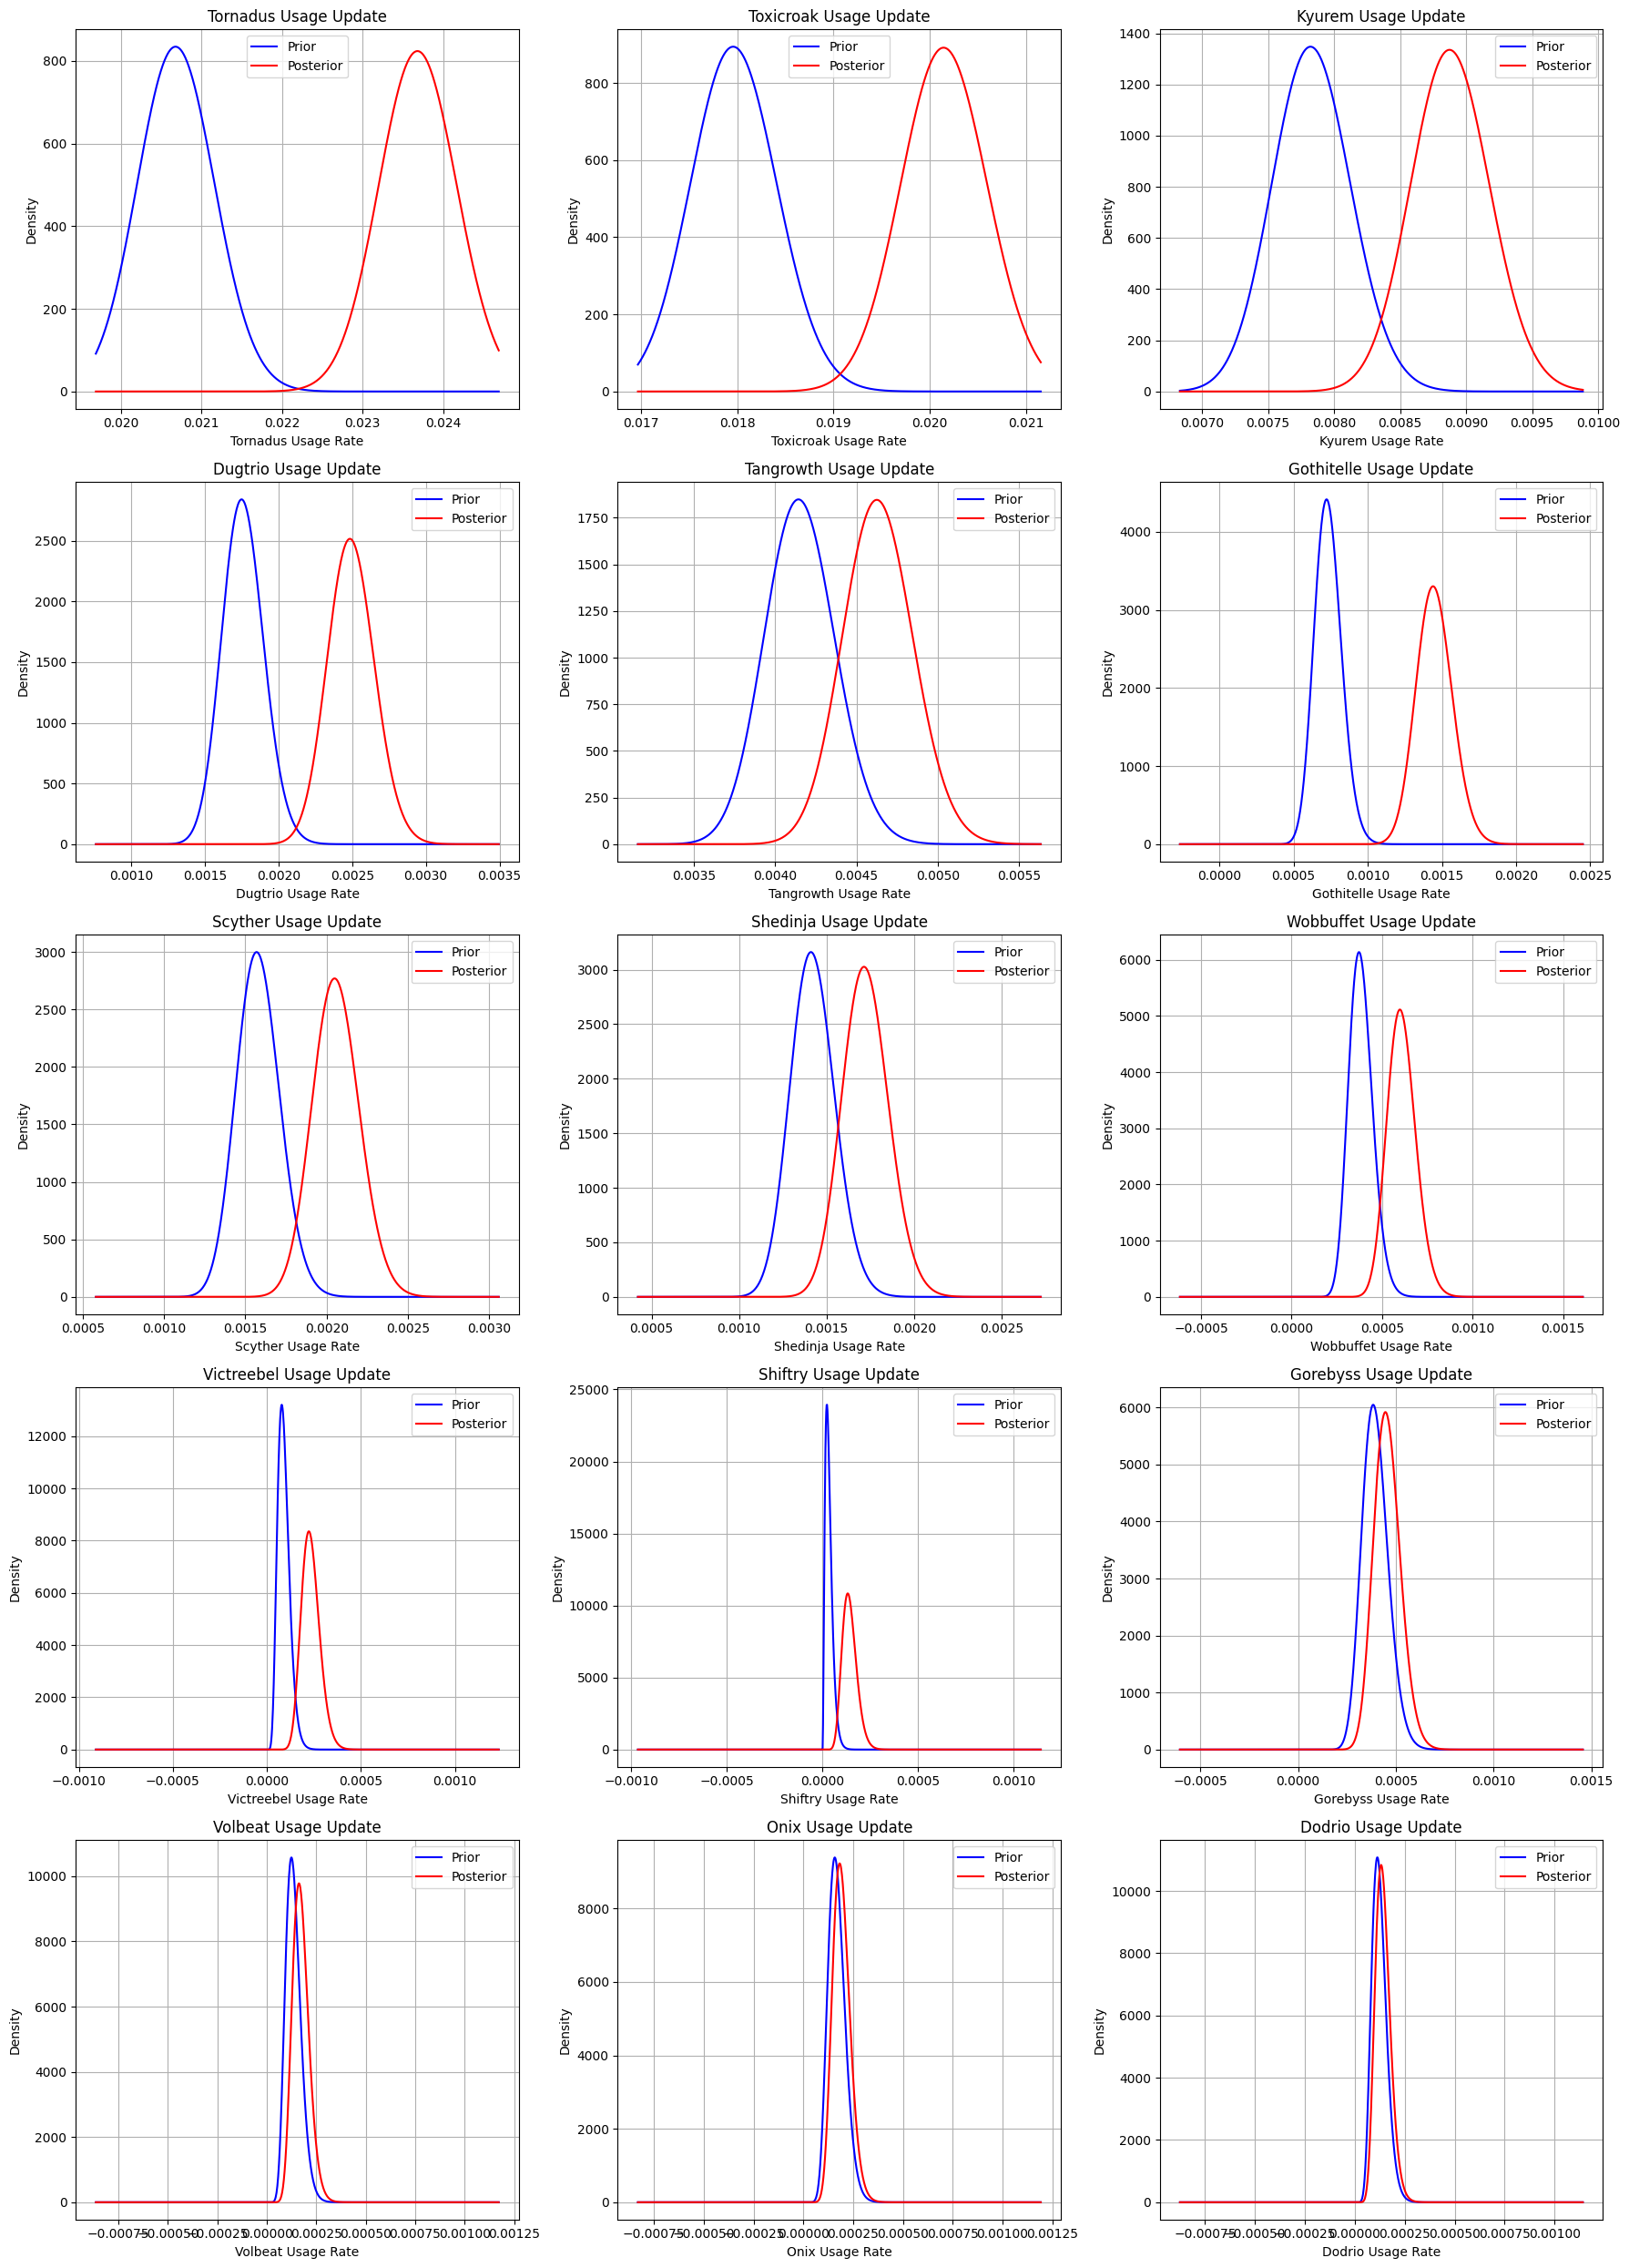

In [105]:
listOfInterest = df_bayes[df_bayes["Bayes Factor"] > 1.1]["Pokemon"].tolist()

# Set number of columns
cols = 3
rows = int(np.ceil(len(listOfInterest) / cols))

fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axs = axs.flatten()  # Flatten in case axs is 2D

for i, pokemon in enumerate(listOfInterest):
    totalPokemonReplay = df_counts[df_counts["Pokemon"] == pokemon]["Observed"].iloc[0]
    expected_data = pokemon_usage_expected[pokemon_usage_expected["Pokemon"] == pokemon]
    if expected_data.empty:
        continue

    totalPokemonUsageExpected = expected_data["Raw"].iloc[0]

    alpha_prior = totalPokemonUsageExpected
    beta_prior = totalTeams - alpha_prior

    alpha_posterior = alpha_prior + totalPokemonReplay
    beta_posterior = beta_prior + (10000 - totalPokemonReplay)

    prior_mean = alpha_prior / (alpha_prior + beta_prior)
    posterior_mean = alpha_posterior / (alpha_posterior + beta_posterior)

    x_vals = np.linspace(min(prior_mean, posterior_mean) - 0.001, max(prior_mean, posterior_mean) + 0.001, 1000)

    axs[i].plot(x_vals, sp.beta.pdf(x_vals, alpha_prior, beta_prior), label="Prior", color="blue")
    axs[i].plot(x_vals, sp.beta.pdf(x_vals, alpha_posterior, beta_posterior), label="Posterior", color="red")
    axs[i].set_title(f"{pokemon} Usage Update")
    axs[i].set_xlabel(f"{pokemon} Usage Rate")
    axs[i].set_ylabel("Density")
    axs[i].legend()
    axs[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
